In [1]:
"""

Your new task will be to use this dataset and use 
attendee_id, event_id and purchase_quad as the feature columns and 
predict or recommend the the purchase_type based on your learning 
of my sent recommendation engine internet site link.

And, do lot of statistical analysis, visualization and some 
correlation check before do the recommendation or prediction 
model train. So, that purpose of prediction and feature dataset 
exploratory analysis done to do insight into dataset columns.

Attendee id is list of ids of unique attendees in the event, 
event_id is event type id, purchase_quad is time of event 
duration time divided into 4 quadrant and purchase_type is 
type of purchase done by the buyer.

Code Example:
https://keras.io/examples/structured_data/collaborative_filtering_movielens/

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('./data/event_1_transactions.csv'
                 , index_col = 0
                )
df.head()

,event_id,attendee_id,order_id,purchase_quad,purchase_type
0,1,342606,3786,2,2
1,1,342606,3786,3,2
2,1,342606,3786,4,0
3,1,342606,3786,1,0
4,1,342606,3786,3,0


## NN Recommender Model

In [3]:
attendee_ids = df["attendee_id"].unique().tolist()
a2a_encoded = {x: i for i, x in enumerate(attendee_ids)}
a_encoded2a = {i: x for i, x in enumerate(attendee_ids)}

type_ids = df["purchase_type"].unique().tolist()
type2type_encoded = {x: i for i, x in enumerate(type_ids)}
type_encoded2type = {i: x for i, x in enumerate(type_ids)}

df["attendee"] = df["attendee_id"].map(a2a_encoded)
df["type"] = df["purchase_type"].map(type2type_encoded)

num_attendee = len(a2a_encoded)
num_type = len(type_encoded2type)

df["purchase_quad"] = df["purchase_quad"].values.astype(np.float32)
# min and max quads will be used to normalize the ratings later
min_quad = min(df["purchase_quad"])
max_quad = max(df["purchase_quad"])

print(
    "Number of Attendees: {}, Number of Purchase Types: {}, Min Quad: {}, Max Quad: {}".format(
        num_attendee, num_type, min_quad, max_quad
    )
)

Number of Attendees: 1996, Number of Purchase Types: 3, Min Quad: 1.0, Max Quad: 4.0


In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["attendee", "type"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["purchase_quad"].apply(lambda x: (x - min_quad) / (max_quad - min_quad)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
x[0], y[0]

(array([1795,    2]), 0.6666666666666666)

## NN Recommender Class

In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_attendee, num_type, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_attendee = num_attendee
        self.num_type = num_type
        self.embedding_size = embedding_size
        self.attendee_embedding = layers.Embedding(
            num_attendee,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.attendee_bias = layers.Embedding(num_attendee, 1)
        self.type_embedding = layers.Embedding(
            num_type,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.type_bias = layers.Embedding(num_type, 1)

    def call(self, inputs):
        attendee_vector = self.attendee_embedding(inputs[:, 0])
        attendee_bias = self.attendee_bias(inputs[:, 0])
        type_vector = self.type_embedding(inputs[:, 1])
        type_bias = self.type_bias(inputs[:, 1])
        dot_attendee_type = tf.tensordot(attendee_vector, type_vector, 2)
        # Add all the components (including bias)
        x = dot_attendee_type + attendee_bias + type_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [7]:
model = RecommenderNet(num_attendee, num_type, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [8]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/50
137/137 [==============================] - 0s 3ms/step - loss: 0.9449 - val_loss: 1.3248
Epoch 2/50
137/137 [==============================] - 0s 2ms/step - loss: 1.1717 - val_loss: 1.1633
Epoch 3/50
137/137 [==============================] - 0s 2ms/step - loss: 1.3871 - val_loss: 1.4053
Epoch 4/50
137/137 [==============================] - 0s 2ms/step - loss: 1.3886 - val_loss: 1.7651
Epoch 5/50
137/137 [==============================] - 0s 2ms/step - loss: 1.5621 - val_loss: 1.5890
Epoch 6/50
137/137 [==============================] - 0s 2ms/step - loss: 1.4402 - val_loss: 1.4773
Epoch 7/50
137/137 [==============================] - 0s 2ms/step - loss: 1.4618 - val_loss: 1.2706
Epoch 8/50
137/137 [==============================] - 0s 2ms/step - loss: 1.3947 - val_loss: 1.2814
Epoch 9/50
137/137 [==============================] - 0s 2ms/step - loss: 1.4242 - val_loss: 1.1992
Epoch 10/50
137/137 [==============================] - 0s 2ms/step - loss: 1.3732 - val_loss: 1.2363

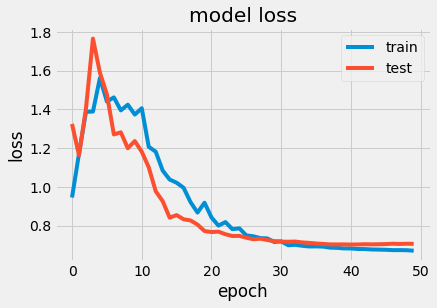

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right");

## Recommendations

In [10]:
attendee_id = df.attendee_id.sample(1).iloc[0]
attendee_id

238699

In [11]:
types_purchased_by_user = df[df.attendee_id == attendee_id]
types_purchased_by_user

,event_id,attendee_id,order_id,purchase_quad,purchase_type,attendee,type
8400,1,238699,3328,3.0,0,1738,1
8402,1,238699,3328,1.0,1,1738,2
8401,1,238699,3328,2.0,0,1738,1


In [12]:
types_not_purchased = df[
    ~df["type"].isin(types_purchased_by_user.type.values)
]["type"]
types_not_purchased

4464    0
2678    0
4352    0
7945    0
6422    0
       ..
4859    0
6439    0
3943    0
3556    0
8322    0
Name: type, Length: 968, dtype: int64

In [13]:
types_not_purchased = list(
    set(types_not_purchased).intersection(set(type2type_encoded.keys()))
)
types_not_purchased

[0]

In [14]:
types_not_purchased = [[type2type_encoded.get(x)] for x in types_not_purchased]
types_not_purchased

[[1]]

In [15]:
attendee_encoder = a2a_encoded.get(attendee_id)
attendee_encoder

1738

In [16]:
attendee_type_array = np.hstack(
    ([[attendee_encoder]] * len(types_not_purchased), types_not_purchased)
)
attendee_type_array

array([[1738,    1]])

In [17]:
ratings = model.predict(attendee_type_array).flatten()
ratings

array([0.4101081], dtype=float32)

In [18]:
top_quad_indices = ratings.argsort()[-3:][::-1]
top_quad_indices

array([0])

In [19]:
recommended_type_ids = [
    type_encoded2type.get(types_not_purchased[x][0]) for x in top_quad_indices
]
recommended_type_ids

[0]